In [4]:
# Cell 1 - imports & settings
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# display options
pd.set_option("display.max_columns", 100)
sns.set_style("whitegrid")

In [5]:
# Cell 2 - auto-detect CSV
csv_files = glob.glob("uber.csv")
print("CSV files found:", csv_files)

# If you know the filename, set it here instead:
# fname = 'uber_fares.csv'
# data = pd.read_csv(fname)

if len(csv_files) == 0:
    raise FileNotFoundError("No CSV files found in working directory. Download the Kaggle dataset and place the CSV here.")

# try to pick a file that looks like Uber dataset otherwise first CSV
fname = None
for f in csv_files:
    if 'uber' in f.lower() or 'fare' in f.lower():
        fname = f
        break
if fname is None:
    fname = csv_files[0]

print("Loading:", fname)
data = pd.read_csv(fname)
data.head()

CSV files found: ['uber.csv']
Loading: uber.csv


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
# Cell 3 - quick info
data.info()
data.describe(include='all').T
print("Columns:", list(data.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
Columns: ['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [7]:
# Cell 4 - preprocessing

# 1) Drop exact duplicates
data.drop_duplicates(inplace=True)

# 2) Drop rows with missing essential fields
essential_cols = ['fare_amount', 'pickup_datetime',
                  'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
for c in essential_cols:
    if c not in data.columns:
        raise KeyError(f"Expected column {c} not found — check column names in your CSV.")
data.dropna(subset=essential_cols, inplace=True)

# 3) Convert pickup_datetime to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')
data = data[~data['pickup_datetime'].isna()]  # remove unparsable datetimes

# 4) Feature engineering - datetime parts
data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday  # Monday=0

# 5) Haversine distance function
from math import radians, cos, sin, asin, sqrt

def haversine_vectorized(lat1, lon1, lat2, lon2):
    # all vectors/series
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Earth radius in kilometers
    return km

data['distance_km'] = haversine_vectorized(
    data['pickup_latitude'], data['pickup_longitude'],
    data['dropoff_latitude'], data['dropoff_longitude']
)

# 6) Clean obvious invalid rows
# remove non-positive distances or extremely large lat/lon outside [-90, 90]/[-180,180]
data = data[(data['distance_km'] >= 0) & (data['distance_km'] < 500)]  # drop absurd long distances
data = data[(data['fare_amount'] > 0) & (data['fare_amount'] < 1000)]    # filter absurd fares
data = data[(data['passenger_count'] >= 1) & (data['passenger_count'] <= 6)]  # typical limits

data.reset_index(drop=True, inplace=True)
print("After cleaning:", data.shape)
data[['fare_amount','distance_km','passenger_count','pickup_hour']].describe()

After cleaning: (198838, 15)


,fare_amount,distance_km,passenger_count,pickup_hour
count,198838.000000,198838.000000,198838.000000,198838.000000
mean,11.361926,3.293401,1.689446,13.492486
std,9.891084,4.294006,1.305275,6.516417
min,0.010000,0.000000,1.000000,0.000000
25%,6.000000,1.213658,1.000000,9.000000
50%,8.500000,2.116977,1.000000,14.000000
75%,12.500000,3.858395,2.000000,19.000000
max,499.000000,407.457236,6.000000,23.000000


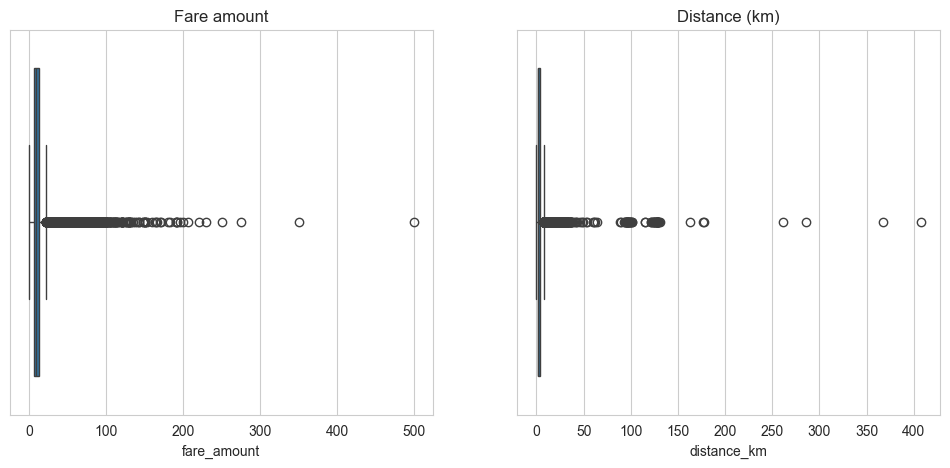

Fare IQR bounds: -3.75 22.25
Distance IQR bounds: -2.753447403484558 7.8254996654688185
Outlier fraction: 0.10162544382864443
Shape after trimming top 1%: (195669, 15)


In [8]:
# Cell 5 - outlier detection visuals
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=data['fare_amount'])
plt.title('Fare amount')

plt.subplot(1,2,2)
sns.boxplot(x=data['distance_km'])
plt.title('Distance (km)')
plt.show()

# IQR method to flag outliers
def iqr_filter(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

fare_lower, fare_upper = iqr_filter(data['fare_amount'], k=1.5)
dist_lower, dist_upper = iqr_filter(data['distance_km'], k=1.5)
print("Fare IQR bounds:", fare_lower, fare_upper)
print("Distance IQR bounds:", dist_lower, dist_upper)

# Fraction of rows beyond bounds
outlier_mask = (data['fare_amount'] > fare_upper) | (data['fare_amount'] < fare_lower) | \
               (data['distance_km'] > dist_upper) | (data['distance_km'] < dist_lower)
print("Outlier fraction:", outlier_mask.mean())

# Optionally remove outliers (example: remove top 1% fares as another approach)
data_no_out = data[(data['fare_amount'] <= data['fare_amount'].quantile(0.99)) &
                   (data['distance_km'] <= data['distance_km'].quantile(0.99))]
print("Shape after trimming top 1%:", data_no_out.shape)

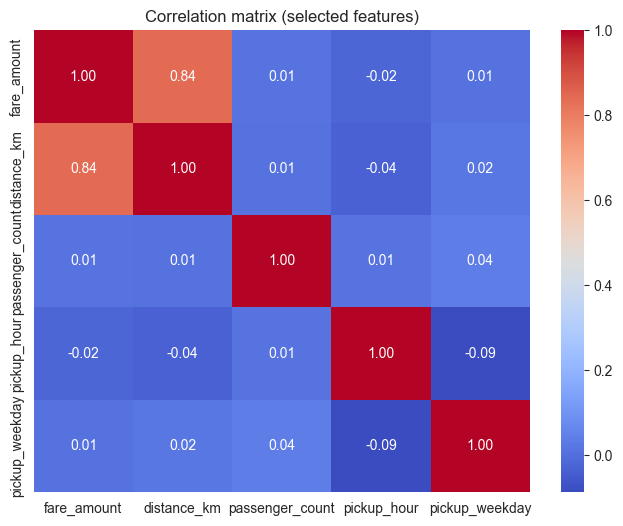

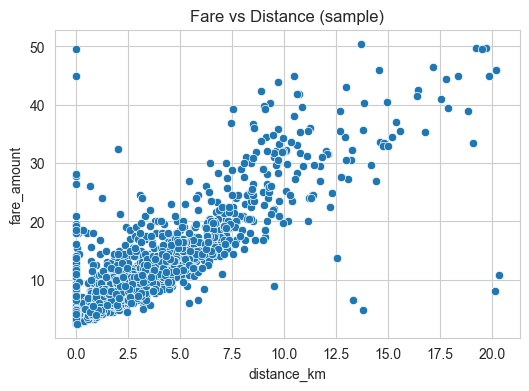

In [9]:
# Cell 6 - correlation matrix
corr_cols = ['fare_amount','distance_km','passenger_count','pickup_hour','pickup_weekday']
corr = data_no_out[corr_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (selected features)")
plt.show()

# Scatter: fare vs distance
plt.figure(figsize=(6,4))
sns.scatterplot(x='distance_km', y='fare_amount', data=data_no_out.sample(2000, random_state=RANDOM_STATE))
plt.title("Fare vs Distance (sample)")
plt.show()

In [10]:
# Cell 7 - features and target
df = data_no_out.copy()

# Features - numeric only for this simple baseline
X = df[['distance_km','passenger_count','pickup_hour','pickup_weekday','pickup_month']]
y = df['fare_amount']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(156535, 5) (39134, 5)


In [11]:
# Cell 8 - Linear Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}

metrics_lr = regression_metrics(y_test, y_pred_lr)
metrics_lr

{'r2': 0.707238897624237, 'rmse': 4.087432912063899, 'mae': 2.3473301905788415}

In [12]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(lr_pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1)
print("LR CV R2 mean:", cv_scores.mean(), "std:", cv_scores.std())

LR CV R2 mean: 0.7099531057678722 std: 0.0037219052809271997


In [13]:
# Cell 9 - Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

metrics_rf = regression_metrics(y_test, y_pred_rf)
metrics_rf

# Cross-validation (R2)
cv_scores_rf = cross_val_score(rf, X, y, scoring='r2', cv=cv, n_jobs=-1)
print("RF CV R2 mean:", cv_scores_rf.mean(), "std:", cv_scores_rf.std())

RF CV R2 mean: 0.7207118347624075 std: 0.0028852191367834718


Linear Regression: {'r2': 0.707238897624237, 'rmse': 4.087432912063899, 'mae': 2.3473301905788415}
Random Forest: {'r2': 0.7169708205411924, 'rmse': 4.0189218093335715, 'mae': 2.3343617704330426}


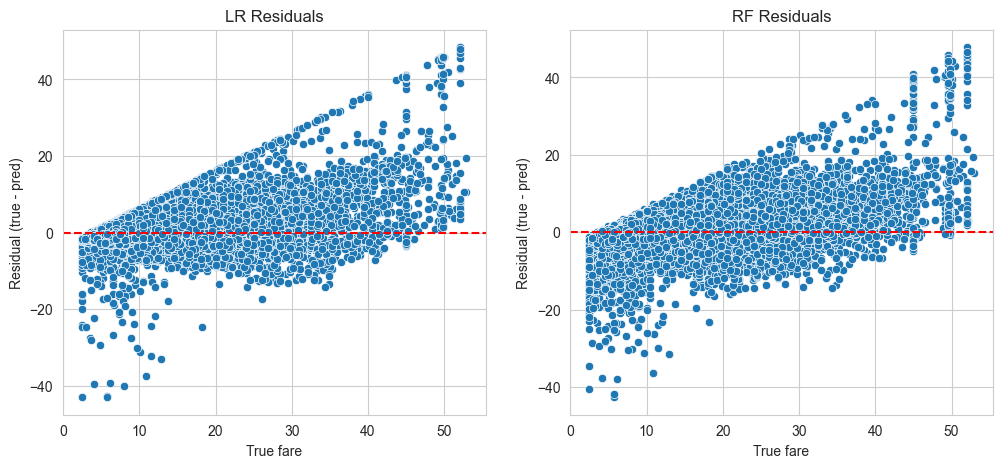

In [14]:
# Cell 10 - compare
print("Linear Regression:", metrics_lr)
print("Random Forest:", metrics_rf)

# Residual plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=(y_test - y_pred_lr))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True fare')
plt.ylabel('Residual (true - pred)')
plt.title('LR Residuals')

plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=(y_test - y_pred_rf))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True fare')
plt.ylabel('Residual (true - pred)')
plt.title('RF Residuals')
plt.show()

In [15]:
# Cell 12 - persist models if you want
import joblib
joblib.dump(lr_pipeline, "lr_pipeline.pkl")
joblib.dump(rf, "rf_model.pkl")

['rf_model.pkl']

In [ ]:
1) Expect distance_km to be the dominant predictor (check feature importances).
2) Random Forest typically gives better RMSE/R2 for non-linear relationships; Linear Regression is a good baseline.
3) Try these improvements:
   - Add pickup/dropoff geospatial clustering (e.g., cluster pickup zones by KMeans) as categorical features.
   - Add travel time estimates (if available) or road network distance instead of haversine.
   - Add surge/time-of-day interaction features and external weather/traffic data.
   - Use LightGBM/XGBoost and tune hyperparameters using randomized search.
   - If many extreme fares exist, consider log-transforming the target (and then back-transforming predictions).